In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
warnings.simplefilter("ignore")

In [2]:
# Определяем количество пользователей в группах
num_users = 1200

In [3]:
# Генерируем данные для группы А 
np.random.seed(0)  # чтобы получить одинаковые результаты
control_group = pd.DataFrame({
    'user_id': np.arange(num_users), 
    'group': 'A',
    'conversion': np.random.choice([0, 1], size = num_users, p = [0.5, 0.5]) #Вероятноть 1 = 0.5
})
# Генерируем данные для группы В
np.random.seed(1)  # чтобы получить одинаковые результаты
test_group = pd.DataFrame({
    'user_id': np.arange((num_users), 2 * num_users),
    'group': 'B',
    'conversion': np.random.choice([0, 1], size = num_users, p = [0.45, 0.55]) #Вероятноть 1 = 0.55 
})
# Cоединяем датафреймы
ab_test_data = pd.concat([control_group, test_group], ignore_index = True)

# Определяем функцию для расчета средних значений bootstrap
def bootstrap_means(data, n_bootstrap_samples=10000): #Создаем 10000 выборок на базе имеющихся
    bootstrap_sample_means = [] # массив средних значений из 10000 выборок
    for _ in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_sample_means.append(bootstrap_sample.mean())
    return bootstrap_sample_means

# Рассчитываем средние значения bootstrap для каждой группы
bootstrap_means_A = bootstrap_means(ab_test_data[ab_test_data['group'] == 'A']['conversion'])
bootstrap_means_B = bootstrap_means(ab_test_data[ab_test_data['group'] == 'B']['conversion'])
print(f'Коэффициент конверсии для контрольной группы = {round(np.mean(bootstrap_means_A)*100)} %')
print(f'Коэффициент конверсии для тестовой группы = {round(np.mean(bootstrap_means_B)*100)} %')

Коэффициент конверсии для контрольной группы = 48 %
Коэффициент конверсии для тестовой группы = 56 %


In [4]:
contingency_table = pd.crosstab(ab_test_data['group'], ab_test_data['conversion'])
a = chi2_contingency(contingency_table)[0:3]

print(f'Хи-квадрат =  {a[0]}')
print(f'p-уровень значимости =  {a[1]}')
print(f'Степеь свободы =  {a[2]}')

Хи-квадрат =  12.636939130434783
p-уровень значимости =  0.00037819870499904336
Степеь свободы =  1


p-уровень значимости меньше 0.05 следовательно группы независимы

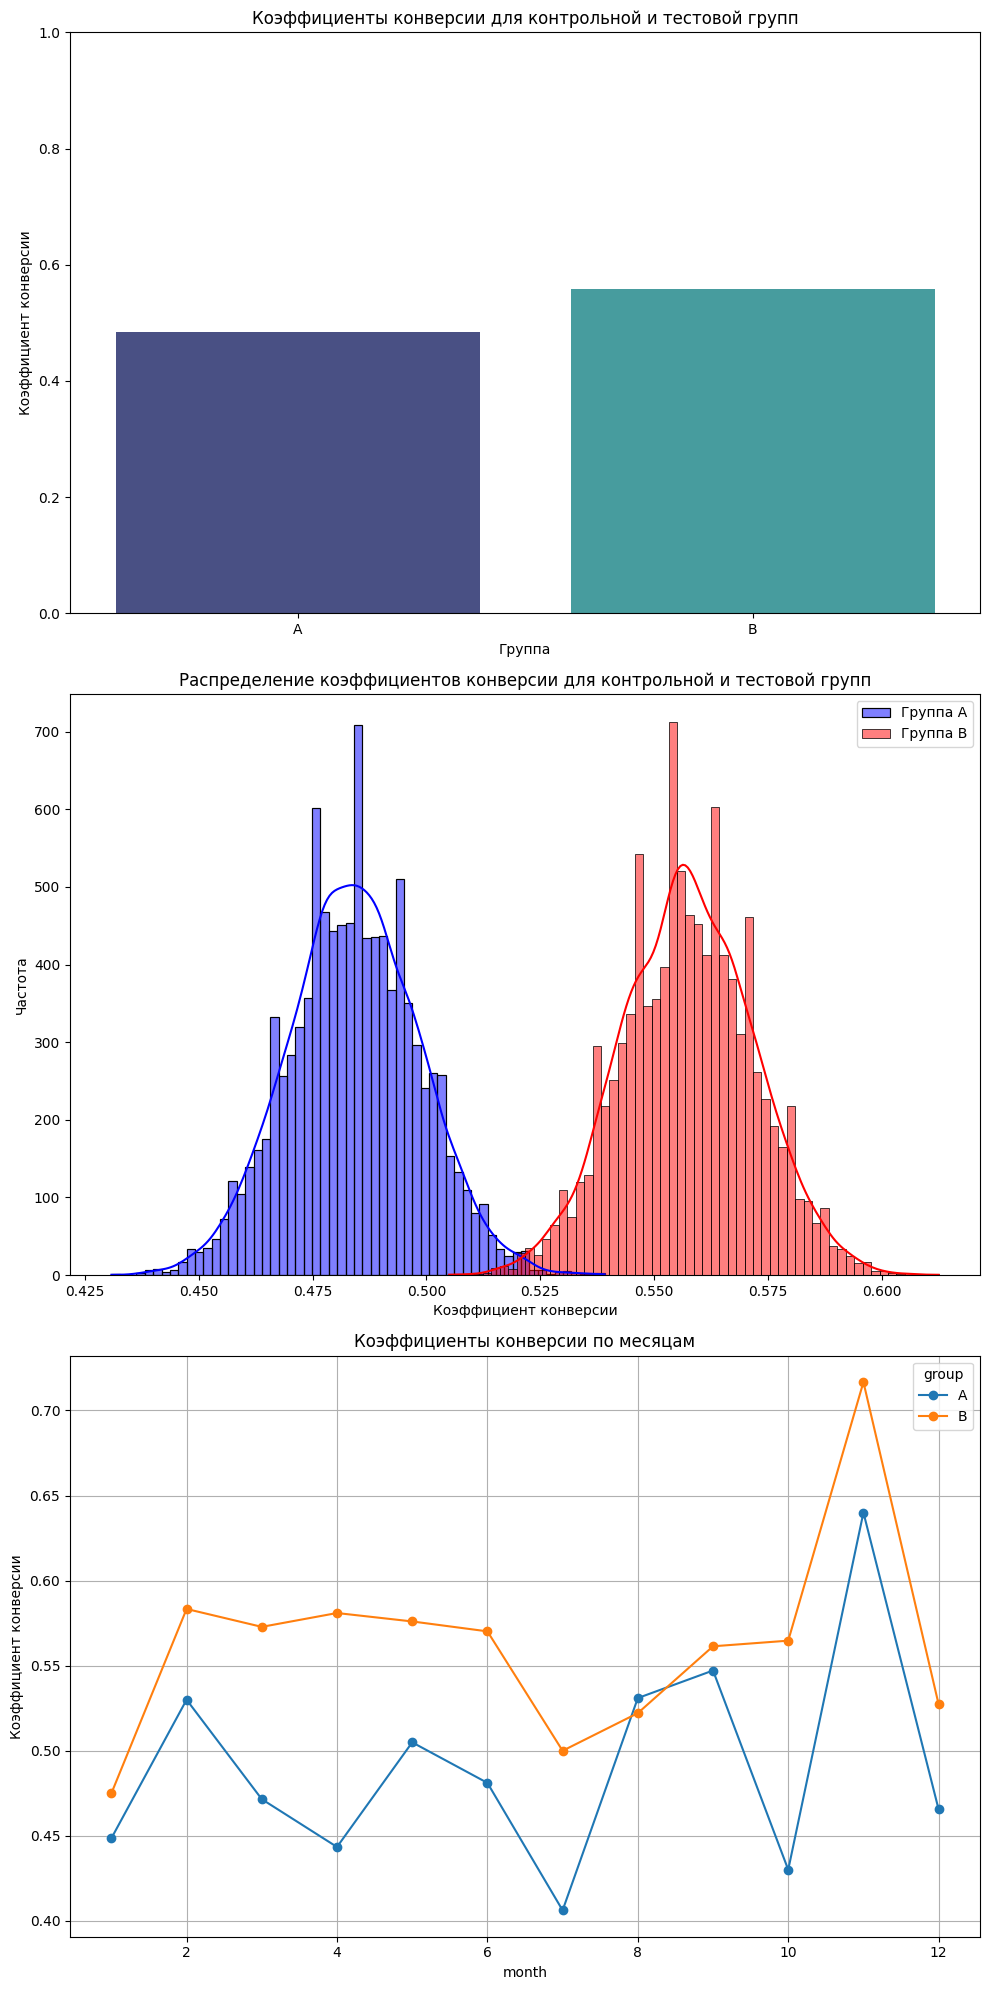

In [5]:
# Перемешаем строки
ab_test_data = ab_test_data.sample(frac = 1)
# Сгенерируйте искусственные метки времени для каждого пользователя, распределенные равномерно в течение 2023 года.
ab_test_data['timestamp'] = pd.date_range(start='1/1/2023', periods=len(ab_test_data), freq='6.57H')
# Генерируем искусственные признаки «месяц» и «год» 
ab_test_data['month'] = ab_test_data['timestamp'].dt.month
ab_test_data['year'] = ab_test_data['timestamp'].dt.year
# Рассчитываем средний коэффициент конверсии по месяцам
conversion_by_month = ab_test_data.groupby(['month', 'group'])['conversion'].mean().unstack()
# Строим графики
fig, ax = plt.subplots(3, 1, figsize=(10, 20))

# Коэффициенты конверсии для контрольной и тестовой групп
conversion_rates = ab_test_data.groupby('group')['conversion'].mean()
sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette="mako", ax=ax[0])
ax[0].set_title('Коэффициенты конверсии для контрольной и тестовой групп')
ax[0].set_ylabel('Коэффициент конверсии')
ax[0].set_xlabel('Группа')
ax[0].set_ylim(0,1)

# Распределение коэффициентов конверсии для контрольной и тестовой групп
sns.histplot(bootstrap_means_A, color='b', kde=True, label='Группа A', ax=ax[1])
sns.histplot(bootstrap_means_B, color='r', kde=True, label='Группа B', ax=ax[1])
ax[1].set_title('Распределение коэффициентов конверсии для контрольной и тестовой групп')
ax[1].set_ylabel('Частота')
ax[1].set_xlabel('Коэффициент конверсии')
ax[1].legend()

# Коэффициенты конверсии по месяцам
conversion_by_month.plot(kind='line', marker='o', ax=ax[2])
ax[2].set_title('Коэффициенты конверсии по месяцам')
ax[2].set_ylabel('Коэффициент конверсии')
ax[2].grid(True)

plt.tight_layout()
plt.show()


Вывод по результатам эксперимента:

Новый дизайн сайта увеличивает конверсии, то есть, доли посетителей сайта, которые совершают покупку
- Коэффициент конверсии для контрольной группы = 48 %
- Коэффициент конверсии для тестовой группы = 56 %
- Хи-квадрат =  12.636939130434783
- p-уровень значимости =  0.00037819870499904336

p-уровень значимости меньше 0.05 следовательно группы независимы
